# Graphical Model

The graphical model can be identified as the figure below. The Latent variable $Z$ is given by the Multinomial Distribution with $\pi$. Here $\pi$ is given as a random variable with Dirichlet Distribution. Each document is comprised of words where the total possible vocabulary count is given as $V$. This indicates that the word distribution for each document can be a count of word appearances given by a vector of length $V$. Since the occurance of any word in every document would be low it makes sense to define the word distribution as a Poisson Distribution with Gamma Prior.

 ![GM](./Graphical_Model.png)


Gibbs Sampling as the name suggests is a sampling algorithm. Since solving for the Posterior is difficult, we instead approximate the posterior distribution probabilistically through sampling. Below are derived equations for sampling $z_n$, $\lambda$, and $\pi$. 


$z_n$ sampling<br>
$\begin{equation}\begin{aligned}z_n \sim P(z_n|z_{1:n-1,n+1:N}, x_{1:N}, \pi_{1:K}, \lambda_{1:K})=\frac{\prod_{k=1}^K[\pi_k\prod_{v=1}^V Poisson(x_{nv}|\lambda_{kv})]^{z_{nk}}}{\sum_{z_n}\prod_{k=1}^K[\pi_k\prod_{v=1}^V Poisson(x_{nv}|\lambda_{kv})]^{z_{nk}}}\end{aligned}\end{equation}$

$\lambda_{kv}$ sampling<br>
$\begin{equation}\begin{aligned}\lambda_{kv} \sim P(\lambda_{kv}|z_{1:N}, x_{1:N}, \pi_{1:k-1,k+1:K})=P(\lambda_{kv}|x_{1:N})\propto P(x_{1:N}|\lambda_{kv})P(\lambda_{kv})=Gamma(\alpha_{kv}+C_{kv},\beta_{kv}+n_{kv})\end{aligned}\end{equation}$<br>
$C_{kv}$ : # of times word v is observed in cluster k<br>
$n_{kv}$ : # of word v in cluster k

$\pi$ sampling<br>
$\begin{equation}\begin{aligned}\pi\sim P(\pi|z_{1:N}, x_{1:N}, \lambda_{1:K})=P(\pi|z_{1:N}) \propto P(z_{1:N}|\pi)P(\pi)=Dirichlet(\alpha_1+N_1,...,\alpha_K+N_k)\end{aligned}\end{equation}$

In [73]:
import numpy as np
import pandas as pd
from scipy.stats import poisson, gamma, dirichlet, multinomial
from tqdm import tqdm

Initially, The vocabulary is imported as a dataframe

In [74]:
data = pd.DataFrame()
vocabs = []
with open('./vocab.txt', 'r') as f:
    for line in f:
        vocabs.append(line.split()[0])

rows = []
count = []
with open('./ap.dat', 'r') as f:
    for line in f:
        tmp = line.split(' ')
        count.append(tmp[0])
        tmp = tmp[1:]
        row = [0] * len(vocabs)
        for elem in tmp:
            index, value = elem.split(':')
            row[int(index)] = int(value)
        rows.append(row)
            
x_data = pd.DataFrame(rows, columns = vocabs)


The initialize_params initializes variables before starting the sampling procedure. The topics are sampled at random and $\lambda$ is sampled from a gamma distribution (to be used as prior for poisson) and $\pi$ is sampled from dirichlet (to be used as prior for multinomial)

In [75]:
def initialize_params(x_data, K, alpha, a, b):
    #topic_assignment: topics of articles
    #topic_word_counts: word count for each topic
    #topic_counts: article count for each topic
    N, V = x_data.shape
    topic_assignments = np.random.randint(0, K, size=N)
    topic_word_counts = np.zeros((K, V))
    topic_counts = np.zeros(K)
    lambdas = gamma.rvs(a, b, size=(K, V))
    pis = dirichlet.rvs(alpha * np.ones(K), size=N)
 

    for i in range(N):
        topic = topic_assignments[i]
        topic_counts[topic] += 1
        topic_word_counts[topic] += x_data[i]

    return topic_assignments, topic_word_counts, topic_counts, lambdas, pis

The overall gibbs algorithm is highlighted within this function. The sampling is done initially through all documents. For each document, the current topic is isolated out. This was done to fix the other values while sampling our new datapoint. Afterwards, the likelihood is calculated from the data and priors. The use of log allows calculating the liklihood using sums. Using the acquired probability distribution, a new topic is sampled.

After all topics are sampled, $\lambda$ is re-sampled from our now changed topics. The general approach is similar to the previous sampling procedure. 

This entire process is done for a given number of iterations. Every 20 iterations (to visualize convergence) we sample out the log proability. 

In [76]:
def gibbs_sampling(x_data, K, alpha, a, b, num_iters=1000):
    N, V = x_data.shape
    topic_assignments, topic_word_counts, topic_counts, lambdas, pis = initialize_params(x_data, K, alpha, a, b)

    log_probs = []
    list_topics = []
    list_lambdas = []
    list_pis = []
    for iteration in tqdm(range(num_iters)):
        for i in range(N):
            # Delete the topic count and topic word count for article i (exclude from sampling)
            current_topic = topic_assignments[i]
            topic_counts[current_topic] -= 1
            topic_word_counts[current_topic] -= x_data[i]
            
            # Compute the log likelihood
            log_topic_probs = np.zeros(K)
            for k in range(K):
                log_topic_word_prob = np.sum(poisson.logpmf(x_data[i], mu=lambdas[k]))
                log_topic_prior_prob = np.log(pis[i, k])
                log_topic_probs[k] = log_topic_word_prob + log_topic_prior_prob

            # Subtract the max log probability to avoid numerical instability
            log_topic_probs = log_topic_probs - np.max(log_topic_probs)
            topic_probs = np.exp(log_topic_probs)
            topic_probs /= topic_probs.sum()

            #print(log_topic_probs)
            # Sample new_topic from a multinomial distribution
            new_topic = np.random.choice(np.arange(K), p=topic_probs)

            # Add the topic count and topic word count for article i (update)
            topic_assignments[i] = new_topic
            topic_counts[new_topic] += 1
            topic_word_counts[new_topic] += x_data[i]

        for k in range(K):
            lambdas[k] = gamma.rvs(a + topic_word_counts[k], scale=1.0/(b + topic_counts[k]))
        pis = dirichlet.rvs(alpha + topic_counts, size=N)   

        # if iteration % 20 ==0:  
        # # compute and store the current log probability
        #     log_poisson = np.sum(poisson.logpmf(x_data, lambdas[topic_assignments]))
        #     log_dirichlet = np.sum(np.log(pis[np.arange(N), topic_assignments]))
        #     log_gamma = np.sum(gamma.logpdf(lambdas, a, scale=1.0/b))
        #     log_multinomial = np.sum(multinomial.logpmf(topic_counts, n=np.sum(topic_counts), p=pis))
        #     log_prob = log_poisson + log_dirichlet + log_gamma + log_multinomial
        #     log_probs.append(log_prob)
        
        
        list_topics.append(topic_assignments)
        list_lambdas.append(lambdas)
        list_pis.append(pis)

    return topic_assignments, topic_word_counts, topic_counts, lambdas, pis, log_probs, list_topics, list_lambdas, list_pis

Poisson distribution will make sense if the probability of a certain vocabulary appearing in a document is very low. Unfortunately words such as 'I' would occur very often which would not make sense for our model. The vocabulary in vocab.txt is sorted in order hence we prune the most frequent words. In order to decrease computation complexity we also prune least frequent words as well. 

In [77]:
## Very Crude Pruning TODO Make this more reliable!

vocabs = []
with open('./vocab.txt', 'r') as f:
    for line in f:
        vocabs.append(line.strip())
        
len(vocabs)
del vocabs[8000:-1]
del vocabs[0:2000]
len(vocabs)
pruned_x = x_data[vocabs]

Setting parameters for priors and the (predetermined) number of classes, we initiate the gibbs sampling. 

In [79]:

# Set parameters
K =10  # Number of topics
alpha = 1.0  # Dirichlet prior parameter alpha
a = 1.0  # Gamma prior parameter a
b = 1.0 # Gamma prior parameter b
# num_iters = 100  # Number of iterations 
num_iters = 200 # Reduced Iterations 

### Take Pruned Value
# x_data_np = x_data.values
x_data_np = pruned_x.values


# Run the Gibbs sampler
print(x_data_np.shape)
topic_assignments, topic_word_counts, topic_counts, lambdas, pis, log_probs, list_topics, list_lambdas, list_pis  = gibbs_sampling(x_data_np, K, alpha, a, b, num_iters)


(2246, 6001)


100%|██████████| 200/200 [15:03<00:00,  4.52s/it]


The following is the convergence graph we sampled during the gibbs sampling procedure.

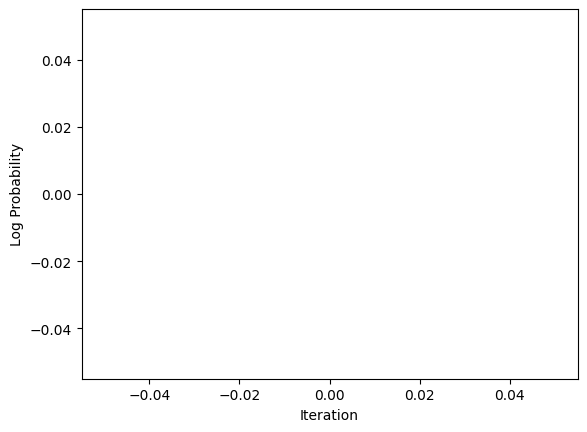

In [80]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# plot the log probabilities per iteration
fig, ax = plt.subplots()
ax.plot(log_probs)

## define the formatter for the y-axis
# def millions(x, pos):
#     return '%1.111111fM' % (x*1e-5)

# formatter = FuncFormatter(millions)

# # apply the formatter to the y-axis
# ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Iteration')
plt.ylabel('Log Probability')
plt.show()

In [102]:
def plot_each_pis(i):
    x = []
    for elem in list_pis:
        x.append(elem[i])
    plt.plot(x)

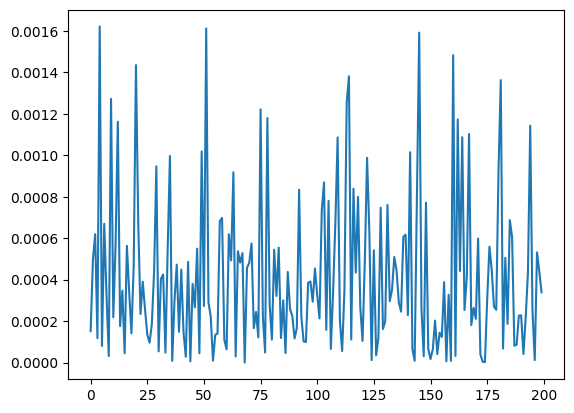

In [106]:
plot_each_pis(0)

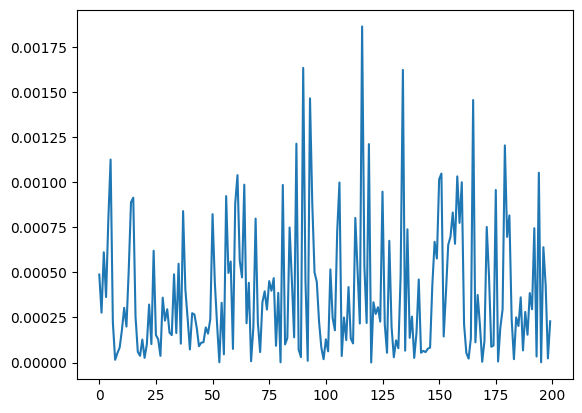

In [107]:
plot_each_pis(1)

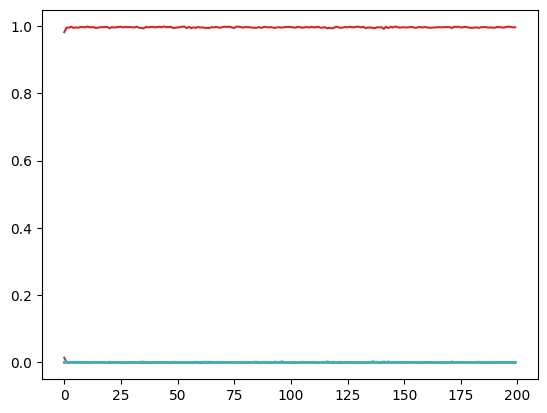

In [97]:
plt.plot(list_pis)

 ...]

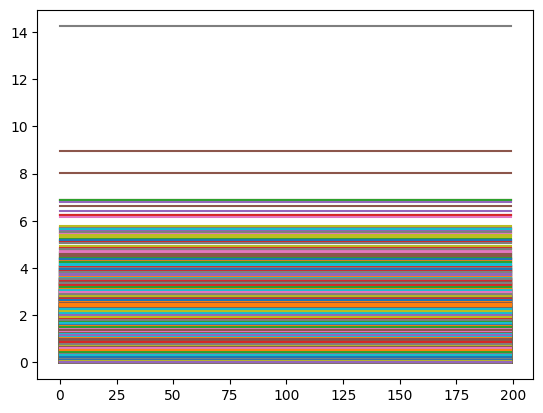

In [94]:
plt.plot(list_lambdas)

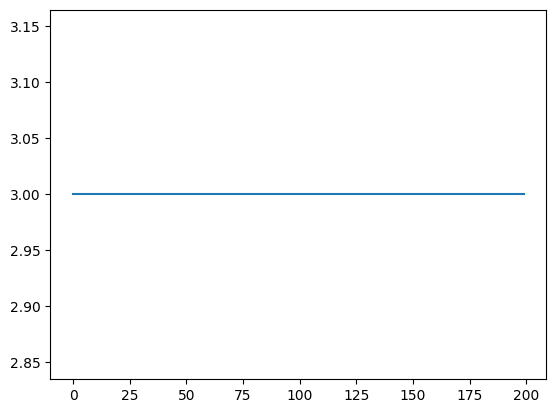

In [108]:
plt.plot(list_topics)

In [ ]:
top_word_index = {}
for idx, ld in enumerate(lambdas):
    top_word_index[idx] =  sorted(range(len(ld)), key=lambda x: ld[x])[-30:]
    top_word_index[idx].reverse()

In [ ]:
toplist = pd.DataFrame()

In [ ]:
for topic in top_word_index:
    # print(f"Topic K={topic}:   ", )
    tmp =[]
    for idx in top_word_index[topic]:
        tmp.append(vocabs[idx])
    toplist[topic] = tmp

For all classes this is the most common vocabularies that are found for each class.

In [ ]:
toplist

,0,1,2,3,4,5,6,7,8,9
0,peabody,globe,sending,strategists,ridley,assembled,fundamentalist,mid,assist,ceremony
1,glenn,brigade,ireland,plate,granting,managed,sinhalese,phil,cookies,coffee
2,laboratory,structures,providing,em,maxwell,separately,insolvent,cftc,offenders,truly
3,utah,zero,liberation,filling,entrance,menorah,europeans,tip,expressing,divorced
4,saudis,marxist,sandinista,pont,incredible,dutch,jeans,cloudy,sat,newly
5,ton,souters,guards,walters,advanced,stepping,janet,acre,extra,mall
6,barash,stability,advertising,technicians,eric,disperse,populations,automatically,shelves,nose
7,guarantee,educate,traditional,extortion,stanford,mid,angolan,nonsmokers,barrels,bottom
8,nagornokarabakh,affiliated,machine,ferret,statute,teitelbaum,alabama,advocate,secretly,writes
9,cream,rough,premier,steep,alongside,automatically,kindergarten,archive,peaceful,dream
